Вариант 5. Упрощенная модель Neural Turing Machine
Реализуйте упрощенную версию Neural Turing Machine с контроллером (простая нейросеть) и внешней памятью (матрица). Контроллер должен выполнять операции записи и чтения из памяти по заданным адресам. Продемонстрируйте запись и чтение последовательности данных.

  Шаг 1 | Вектор A: [1. 0. 0. 0.]  →  ячейка [6] (вес=0.146)
  Шаг 2 | Вектор B: [0. 1. 0. 0.]  →  ячейка [6] (вес=0.146)
  Шаг 3 | Вектор C: [0.5 0.5 0.  0. ]  →  ячейка [6] (вес=0.146)
  Шаг 4 | Вектор D: [0. 0. 1. 0.]  →  ячейка [6] (вес=0.136)
  Шаг 5 | Вектор E: [0.  0.  0.5 0.5]  →  ячейка [6] (вес=0.142)

  Состояние памяти после записи:
  Ячейка    dim0  dim1  dim2  dim3  [0]     +0.007  +0.020  +0.022  -0.111
  [1]     +0.007  +0.022  +0.025  -0.125
  [2]     +0.008  +0.022  +0.025  -0.125
  [3]     +0.007  +0.021  +0.024  -0.118
  [4]     +0.008  +0.022  +0.025  -0.123
  [5]     +0.007  +0.021  +0.024  -0.118
  [6]     +0.009  +0.025  +0.028  -0.140
  [7]     +0.007  +0.021  +0.024  -0.121

  Запрос похожий на Вектор A
  Запрос    : [1. 0. 0. 0.]
  Ячейка    : [5] (вес=0.147)
  Прочитано : [ 0.013  0.027  0.032 -0.147]
  Выход NTM : [-0.059 -0.016  0.085  0.081]

  Запрос похожий на Вектор B
  Запрос    : [0. 1. 0. 0.]
  Ячейка    : [5] (вес=0.141)
  Прочитано : [ 0.016  0.03

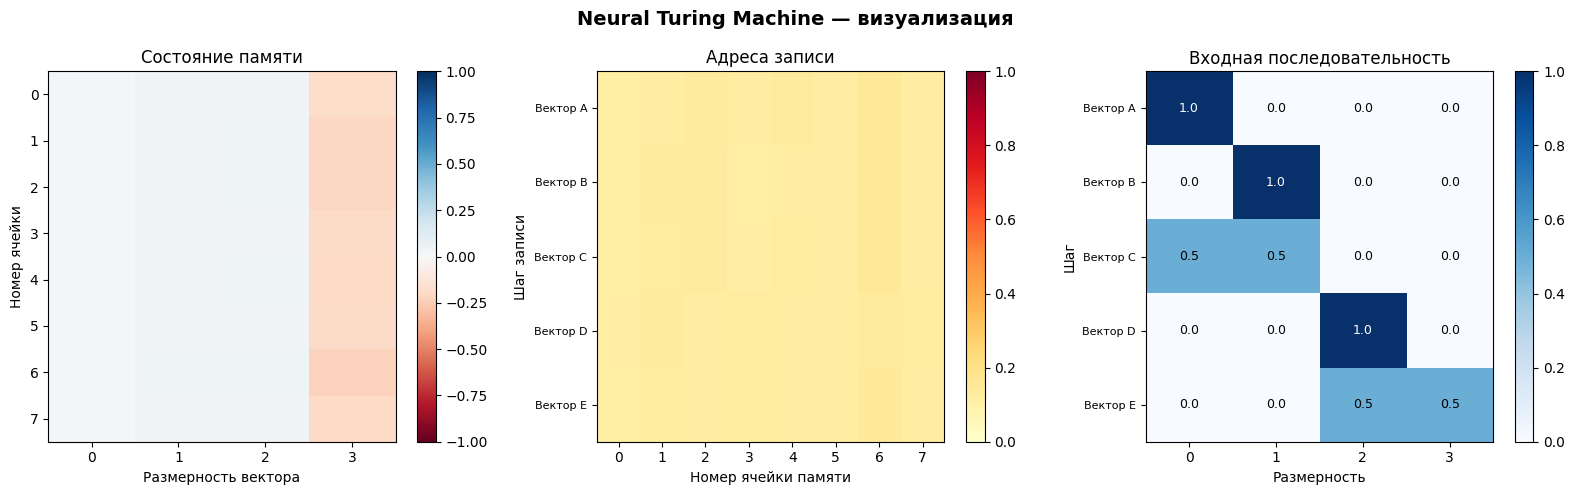

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class ExternalMemory:
    def __init__(self, num_slots: int, slot_size: int):
        self.N = num_slots
        self.M = slot_size
        self.reset()

    def reset(self):
        self.memory = torch.zeros(self.N, self.M)

    def write(self, address: torch.Tensor, data: torch.Tensor):
        self.memory = self.memory + torch.outer(address, data)

    def read(self, address: torch.Tensor) -> torch.Tensor:
        return address @ self.memory

    def get_state(self) -> np.ndarray:
        return self.memory.detach().numpy()


class NTMController(nn.Module):
    def __init__(self, input_size, output_size, num_slots, slot_size, hidden_size=64):
        super().__init__()
        self.N = num_slots
        self.M = slot_size

        controller_input = input_size + slot_size

        self.fc1 = nn.Linear(controller_input, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.write_addr_head = nn.Linear(hidden_size, num_slots)
        self.read_addr_head  = nn.Linear(hidden_size, num_slots)
        self.write_data_head = nn.Linear(hidden_size, slot_size)
        self.output_head     = nn.Linear(hidden_size, output_size)

    def forward(self, x, prev_read):
        inp = torch.cat([x, prev_read], dim=-1)
        h = F.relu(self.fc1(inp))
        h = F.relu(self.fc2(h))

        write_addr = F.softmax(self.write_addr_head(h), dim=-1)
        read_addr  = F.softmax(self.read_addr_head(h),  dim=-1)
        write_data = torch.tanh(self.write_data_head(h))

        return write_addr, read_addr, write_data, h


class SimplifiedNTM(nn.Module):
    def __init__(self, input_size, output_size, num_slots=8, slot_size=4, hidden_size=64):
        super().__init__()
        self.memory      = ExternalMemory(num_slots, slot_size)
        self.controller  = NTMController(input_size, output_size, num_slots, slot_size, hidden_size)
        self.output_head = nn.Linear(hidden_size + slot_size, output_size)
        self.M = slot_size

    def reset(self):
        self.memory.reset()

    def step(self, x, prev_read):
        write_addr, read_addr, write_data, h = self.controller(x, prev_read)
        self.memory.write(write_addr, write_data)
        read_vec = self.memory.read(read_addr)
        out = torch.tanh(self.output_head(torch.cat([h, read_vec], dim=-1)))
        return out, read_vec, write_addr, read_addr, write_data


torch.manual_seed(42)

INPUT_SIZE  = 4
OUTPUT_SIZE = 4
NUM_SLOTS   = 8
SLOT_SIZE   = 4

ntm = SimplifiedNTM(INPUT_SIZE, OUTPUT_SIZE, NUM_SLOTS, SLOT_SIZE)
ntm.eval()

sequence = [
    torch.tensor([1.0, 0.0, 0.0, 0.0]),
    torch.tensor([0.0, 1.0, 0.0, 0.0]),
    torch.tensor([0.5, 0.5, 0.0, 0.0]),
    torch.tensor([0.0, 0.0, 1.0, 0.0]),
    torch.tensor([0.0, 0.0, 0.5, 0.5]),
]
labels = ["Вектор A", "Вектор B", "Вектор C", "Вектор D", "Вектор E"]

ntm.reset()
prev_read = torch.zeros(SLOT_SIZE)
write_addrs_log = []

with torch.no_grad():
    for i, (vec, lbl) in enumerate(zip(sequence, labels)):
        out, prev_read, w_addr, r_addr, w_data = ntm.step(vec, prev_read)
        write_addrs_log.append(w_addr.numpy())
        top_slot = w_addr.argmax().item()
        print(f"  Шаг {i+1} | {lbl}: {vec.numpy()}  →  ячейка [{top_slot}] (вес={w_addr[top_slot]:.3f})")

print(f"\n  Состояние памяти после записи:")
print(f"  {'Ячейка':<8}", end="")
for j in range(SLOT_SIZE):
    print(f"  dim{j}", end="")
mem = ntm.memory.get_state()
for slot_i in range(NUM_SLOTS):
    vals = "  ".join(f"{v:+.3f}" for v in mem[slot_i])
    print(f"  [{slot_i}]     {vals}")


read_queries = [
    (torch.tensor([1.0, 0.0, 0.0, 0.0]), "Запрос похожий на Вектор A"),
    (torch.tensor([0.0, 1.0, 0.0, 0.0]), "Запрос похожий на Вектор B"),
    (torch.tensor([0.0, 0.0, 1.0, 0.0]), "Запрос похожий на Вектор D"),
]

with torch.no_grad():
    for query, desc in read_queries:
        out, read_vec, w_addr, r_addr, _ = ntm.step(query, prev_read)
        top_slot = r_addr.argmax().item()
        print(f"\n  {desc}")
        print(f"  Запрос    : {query.numpy()}")
        print(f"  Ячейка    : [{top_slot}] (вес={r_addr[top_slot]:.3f})")
        print(f"  Прочитано : {read_vec.detach().numpy().round(3)}")
        print(f"  Выход NTM : {out.detach().numpy().round(3)}")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Neural Turing Machine — визуализация", fontsize=14, fontweight="bold")

ax = axes[0]
im = ax.imshow(ntm.memory.get_state(), cmap="RdBu", aspect="auto", vmin=-1, vmax=1)
ax.set_title("Состояние памяти")
ax.set_xlabel("Размерность вектора")
ax.set_ylabel("Номер ячейки")
ax.set_xticks(range(SLOT_SIZE))
ax.set_yticks(range(NUM_SLOTS))
plt.colorbar(im, ax=ax)

ax = axes[1]
write_matrix = np.array(write_addrs_log)
im2 = ax.imshow(write_matrix, cmap="YlOrRd", aspect="auto", vmin=0, vmax=1)
ax.set_title("Адреса записи")
ax.set_xlabel("Номер ячейки памяти")
ax.set_ylabel("Шаг записи")
ax.set_xticks(range(NUM_SLOTS))
ax.set_yticks(range(len(sequence)))
ax.set_yticklabels(labels, fontsize=8)
plt.colorbar(im2, ax=ax)

ax = axes[2]
seq_matrix = np.array([v.numpy() for v in sequence])
im3 = ax.imshow(seq_matrix, cmap="Blues", aspect="auto", vmin=0, vmax=1)
ax.set_title("Входная последовательность")
ax.set_xlabel("Размерность")
ax.set_ylabel("Шаг")
ax.set_xticks(range(INPUT_SIZE))
ax.set_yticks(range(len(sequence)))
ax.set_yticklabels(labels, fontsize=8)
for i in range(len(sequence)):
    for j in range(INPUT_SIZE):
        ax.text(j, i, f"{seq_matrix[i,j]:.1f}", ha="center", va="center",
                fontsize=9, color="white" if seq_matrix[i,j] > 0.5 else "black")
plt.colorbar(im3, ax=ax)

plt.tight_layout()
plt.savefig("ntm_demo.png", dpi=150, bbox_inches="tight")
plt.show()

Вариант 3. Симуляция энергопотребления
Реализуйте класс NeuromorphicChip, который симулирует энергопотребление в зависимости от активности нейронов. Каждый спайк потребляет определенную энергию. В состоянии покоя энергопотребление минимально. Сравните энергопотребление нейроморфного чипа с классическим процессором (симуляция) при обработке одного и того же разреженного входного сигнала.

   СИМУЛЯЦИЯ ЭНЕРГОПОТРЕБЛЕНИЯ: НЕЙРОМОРФНЫЙ ЧИП vs CPU
  Нейронов / юнитов  : 1000
  Шагов симуляции    : 50
  Разреженность      : 5% активных нейронов
  Параметр                            Нейроморфный          CPU
  Энергия на спайк/операцию (Дж)              1e-9         1e-7
  Энергия покоя на нейрон (Дж)               1e-12        5e-6*
  Суммарная энергия (мкДж)                  1.7400    5250.0000
  Средняя энергия за шаг (мкДж)           0.034800   105.000000
  Экономия энергии   : 100.0%
  Нейроморфный чип эффективнее в 3017.2x раз

  Детализация (первые 5 шагов) — Нейроморфный чип:
  Шаг   Спайков    E_спайк (нДж)    E_покой (пДж)    Итого (нДж) 
  0     31         31.0000          1000.00          32.0000     
  1     35         35.0000          1000.00          36.0000     
  2     32         32.0000          1000.00          33.0000     
  3     35         35.0000          1000.00          36.0000     
  4     27         27.0000          1000.00          28.0000     


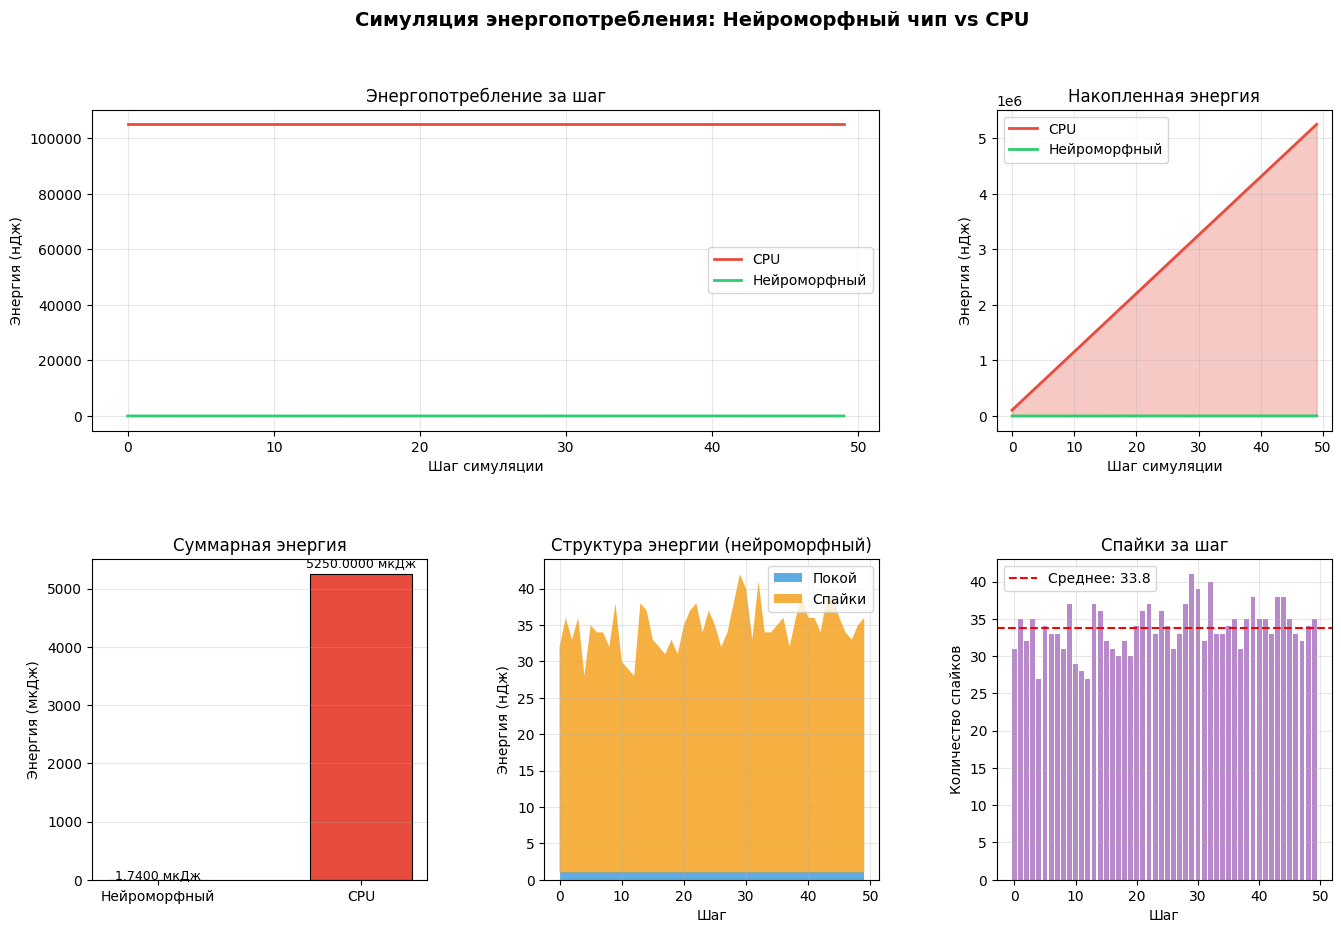

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dataclasses import dataclass, field
from typing import List


@dataclass
class EnergyLog:
    step: int
    active_neurons: int
    spikes: int
    spike_energy: float
    idle_energy: float
    total_energy: float


class NeuromorphicChip:
    def __init__(self, num_neurons: int, spike_energy: float = 1e-9,
                 idle_energy_per_neuron: float = 1e-12, threshold: float = 0.5):
        self.num_neurons = num_neurons
        self.spike_energy = spike_energy
        self.idle_energy_per_neuron = idle_energy_per_neuron
        self.threshold = threshold
        self.membrane_potentials = np.zeros(num_neurons)
        self.total_energy = 0.0
        self.logs: List[EnergyLog] = []

    def reset(self):
        self.membrane_potentials = np.zeros(self.num_neurons)
        self.total_energy = 0.0
        self.logs = []

    def process(self, input_signal: np.ndarray, step: int) -> np.ndarray:
        self.membrane_potentials += input_signal
        spikes = self.membrane_potentials >= self.threshold
        self.membrane_potentials[spikes] = 0.0

        num_spikes = spikes.sum()
        active_neurons = (input_signal > 0).sum()

        spike_e = num_spikes * self.spike_energy
        idle_e  = self.num_neurons * self.idle_energy_per_neuron
        total_e = spike_e + idle_e

        self.total_energy += total_e
        self.logs.append(EnergyLog(step, int(active_neurons), int(num_spikes),
                                   spike_e, idle_e, total_e))
        return spikes


class ClassicalProcessor:
    def __init__(self, num_units: int, energy_per_op: float = 1e-7,
                 idle_energy: float = 5e-6):
        self.num_units = num_units
        self.energy_per_op = energy_per_op
        self.idle_energy = idle_energy
        self.total_energy = 0.0
        self.logs: List[EnergyLog] = []

    def reset(self):
        self.total_energy = 0.0
        self.logs = []

    def process(self, input_signal: np.ndarray, step: int) -> np.ndarray:
        ops = self.num_units
        active = (input_signal > 0).sum()

        op_energy   = ops * self.energy_per_op
        total_e     = op_energy + self.idle_energy

        self.total_energy += total_e
        self.logs.append(EnergyLog(step, int(active), 0, op_energy,
                                   self.idle_energy, total_e))
        return input_signal >= 0.5


np.random.seed(42)

NUM_NEURONS = 1000
NUM_STEPS   = 50
SPARSITY    = 0.05

sparse_signals = []
for _ in range(NUM_STEPS):
    signal = np.zeros(NUM_NEURONS)
    active_idx = np.random.choice(NUM_NEURONS, int(NUM_NEURONS * SPARSITY), replace=False)
    signal[active_idx] = np.random.uniform(0.3, 0.8, len(active_idx))
    sparse_signals.append(signal)

neuro_chip = NeuromorphicChip(num_neurons=NUM_NEURONS,
                               spike_energy=1e-9,
                               idle_energy_per_neuron=1e-12,
                               threshold=0.5)

cpu = ClassicalProcessor(num_units=NUM_NEURONS,
                          energy_per_op=1e-7,
                          idle_energy=5e-6)

for step, signal in enumerate(sparse_signals):
    neuro_chip.process(signal, step)
    cpu.process(signal, step)

neuro_total = neuro_chip.total_energy
cpu_total   = cpu.total_energy
savings     = (1 - neuro_total / cpu_total) * 100

print("   СИМУЛЯЦИЯ ЭНЕРГОПОТРЕБЛЕНИЯ: НЕЙРОМОРФНЫЙ ЧИП vs CPU")
print(f"  Нейронов / юнитов  : {NUM_NEURONS}")
print(f"  Шагов симуляции    : {NUM_STEPS}")
print(f"  Разреженность      : {SPARSITY*100:.0f}% активных нейронов")
print(f"  {'Параметр':<35} {'Нейроморфный':>12} {'CPU':>12}")
print(f"  {'Энергия на спайк/операцию (Дж)':<35} {'1e-9':>12} {'1e-7':>12}")
print(f"  {'Энергия покоя на нейрон (Дж)':<35} {'1e-12':>12} {'5e-6*':>12}")
print(f"  {'Суммарная энергия (мкДж)':<35} {neuro_total*1e6:>12.4f} {cpu_total*1e6:>12.4f}")
print(f"  {'Средняя энергия за шаг (мкДж)':<35} {neuro_total/NUM_STEPS*1e6:>12.6f} {cpu_total/NUM_STEPS*1e6:>12.6f}")
print(f"  Экономия энергии   : {savings:.1f}%")
print(f"  Нейроморфный чип эффективнее в {cpu_total/neuro_total:.1f}x раз")

print(f"\n  Детализация (первые 5 шагов) — Нейроморфный чип:")
print(f"  {'Шаг':<5} {'Спайков':<10} {'E_спайк (нДж)':<16} {'E_покой (пДж)':<16} {'Итого (нДж)':<12}")
for log in neuro_chip.logs[:5]:
    print(f"  {log.step:<5} {log.spikes:<10} {log.spike_energy*1e9:<16.4f} "
          f"{log.idle_energy*1e12:<16.2f} {log.total_energy*1e9:<12.4f}")

fig = plt.figure(figsize=(16, 10))
fig.suptitle("Симуляция энергопотребления: Нейроморфный чип vs CPU",
             fontsize=14, fontweight="bold")
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

steps = list(range(NUM_STEPS))
neuro_step_e = [l.total_energy * 1e9 for l in neuro_chip.logs]
cpu_step_e   = [l.total_energy * 1e9 for l in cpu.logs]
neuro_cumsum = np.cumsum(neuro_step_e)
cpu_cumsum   = np.cumsum(cpu_step_e)
spikes_per_step = [l.spikes for l in neuro_chip.logs]

ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(steps, cpu_step_e,   color="#e74c3c", linewidth=2, label="CPU")
ax1.plot(steps, neuro_step_e, color="#2ecc71", linewidth=2, label="Нейроморфный")
ax1.set_title("Энергопотребление за шаг")
ax1.set_xlabel("Шаг симуляции")
ax1.set_ylabel("Энергия (нДж)")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 2])
ax2.fill_between(steps, cpu_cumsum,   alpha=0.3, color="#e74c3c")
ax2.fill_between(steps, neuro_cumsum, alpha=0.3, color="#2ecc71")
ax2.plot(steps, cpu_cumsum,   color="#e74c3c", linewidth=2, label="CPU")
ax2.plot(steps, neuro_cumsum, color="#2ecc71", linewidth=2, label="Нейроморфный")
ax2.set_title("Накопленная энергия")
ax2.set_xlabel("Шаг симуляции")
ax2.set_ylabel("Энергия (нДж)")
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 0])
bars = ax3.bar(["Нейроморфный", "CPU"],
               [neuro_total * 1e6, cpu_total * 1e6],
               color=["#2ecc71", "#e74c3c"], width=0.5, edgecolor="black", linewidth=0.8)
for bar, val in zip(bars, [neuro_total * 1e6, cpu_total * 1e6]):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
             f"{val:.4f} мкДж", ha="center", fontsize=9)
ax3.set_title("Суммарная энергия")
ax3.set_ylabel("Энергия (мкДж)")
ax3.grid(True, alpha=0.3, axis="y")

ax4 = fig.add_subplot(gs[1, 1])
neuro_spike_e = [l.spike_energy * 1e9 for l in neuro_chip.logs]
neuro_idle_e  = [l.idle_energy  * 1e9 for l in neuro_chip.logs]
ax4.stackplot(steps, neuro_idle_e, neuro_spike_e,
              labels=["Покой", "Спайки"],
              colors=["#3498db", "#f39c12"], alpha=0.8)
ax4.set_title("Структура энергии (нейроморфный)")
ax4.set_xlabel("Шаг")
ax4.set_ylabel("Энергия (нДж)")
ax4.legend(loc="upper right")
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 2])
ax5.bar(steps, spikes_per_step, color="#9b59b6", alpha=0.7, width=0.8)
ax5.axhline(np.mean(spikes_per_step), color="red", linestyle="--",
            linewidth=1.5, label=f"Среднее: {np.mean(spikes_per_step):.1f}")
ax5.set_title("Спайки за шаг")
ax5.set_xlabel("Шаг")
ax5.set_ylabel("Количество спайков")
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.savefig("neuromorphic_energy.png", dpi=150, bbox_inches="tight")
plt.show()

Вариант 4. Zero-shot классификация с использованием LLM
Используйте LLM (через API или Hugging Face) для zero-shot классификации текстов. Создайте список текстов и список возможных категорий. Для каждого текста определите наиболее подходящую категорию без предварительного обучения на этих категориях.

  ZERO-SHOT КЛАССИФИКАЦИЯ ТЕКСТОВ
  Модель: facebook/bart-large-mnli
  Текстов    : 10
  Категорий  : 8


Device set to use cpu


 №                                               Текст Предсказание     Правда Уверенность Верно?
 1 The stock market crashed today as investors fear...      Финансы    Финансы       45.2%      ✓
 2 Scientists discovered a new species of deep-sea ...        Наука      Наука       84.9%      ✓
 3 The championship game ended with a last-minute g...        Спорт      Спорт       61.3%      ✓
 4 A new blockbuster film broke box office records ...         Кино       Кино       57.9%      ✓
 5 Doctors recommend a new treatment for patients w...     Медицина   Медицина       71.7%      ✓
 6 The government announced a new policy to reduce ...     Политика   Политика       48.3%      ✓
 7 Astronomers detected gravitational waves from tw...   Астрономия      Наука       58.1%      ✗
 8 The local football club signed a new striker for...        Спорт      Спорт       69.1%      ✓
 9 Tech giant released a new smartphone with revolu...   Технологии Технологии       93.8%      ✓
10 Researchers found

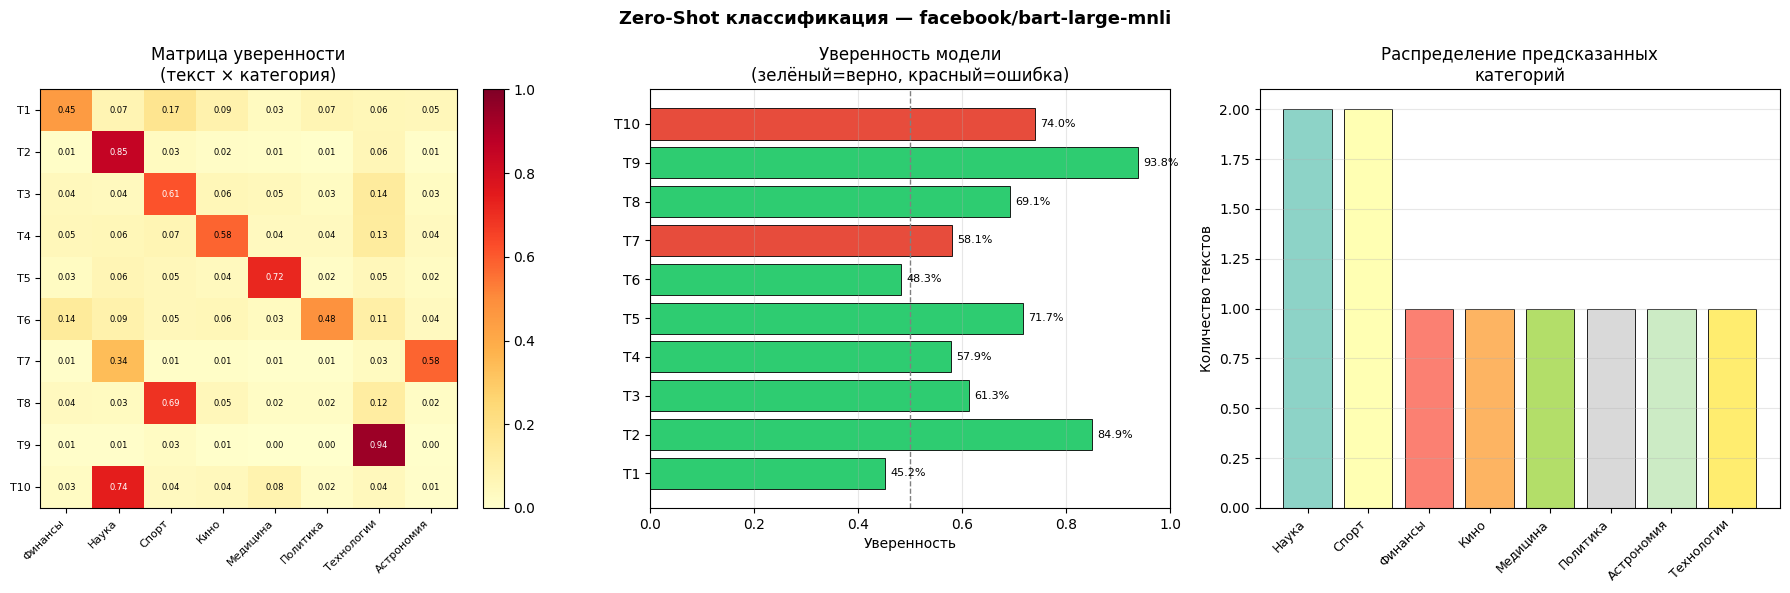

In [21]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

texts = [
    "The stock market crashed today as investors feared rising inflation.",
    "Scientists discovered a new species of deep-sea fish near the Mariana Trench.",
    "The championship game ended with a last-minute goal from the home team.",
    "A new blockbuster film broke box office records in its opening weekend.",
    "Doctors recommend a new treatment for patients with type 2 diabetes.",
    "The government announced a new policy to reduce carbon emissions by 2030.",
    "Astronomers detected gravitational waves from two merging black holes.",
    "The local football club signed a new striker for a record transfer fee.",
    "Tech giant released a new smartphone with revolutionary battery technology.",
    "Researchers found a link between sleep deprivation and memory loss.",
]

categories = ["Финансы", "Наука", "Спорт", "Кино", "Медицина",
              "Политика", "Технологии", "Астрономия"]

categories_en = ["Finance", "Science", "Sport", "Cinema", "Medicine",
                 "Politics", "Technology", "Astronomy"]

true_labels = [
    "Финансы", "Наука", "Спорт", "Кино", "Медицина",
    "Политика", "Наука", "Спорт", "Технологии", "Медицина"
]

print("  ZERO-SHOT КЛАССИФИКАЦИЯ ТЕКСТОВ")
print("  Модель: facebook/bart-large-mnli")
print(f"  Текстов    : {len(texts)}")
print(f"  Категорий  : {len(categories)}")

classifier = pipeline(
    task="zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=-1
)

results = []
for i, text in enumerate(texts):
    output = classifier(text, candidate_labels=categories_en, multi_label=False)

    en_to_ru = dict(zip(categories_en, categories))
    top_label_en = output["labels"][0]
    top_label_ru = en_to_ru[top_label_en]
    top_score    = output["scores"][0]

    scores_ru = {en_to_ru[en]: sc for en, sc in zip(output["labels"], output["scores"])}

    results.append({
        "text":        text,
        "predicted":   top_label_ru,
        "true":        true_labels[i],
        "confidence":  top_score,
        "correct":     top_label_ru == true_labels[i],
        "scores":      scores_ru,
    })
    
correct  = sum(r["correct"] for r in results)
accuracy = correct / len(results)

df = pd.DataFrame({
    "№":           range(1, len(results)+1),
    "Текст":       [r["text"][:48]+"..." for r in results],
    "Предсказание":  [r["predicted"]   for r in results],
    "Правда":      [r["true"]        for r in results],
    "Уверенность": [f"{r['confidence']*100:.1f}%" for r in results],
    "Верно?":      ["✓" if r["correct"] else "✗" for r in results],
})

pd.set_option("display.max_colwidth", 55)
pd.set_option("display.width", 130)
print(df.to_string(index=False))
print(f"  Правильных : {correct} / {len(results)}")
print(f"  Accuracy   : {accuracy*100:.1f}%")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Zero-Shot классификация — facebook/bart-large-mnli",
             fontsize=13, fontweight="bold")

score_matrix = np.zeros((len(texts), len(categories)))
for i, r in enumerate(results):
    for j, cat in enumerate(categories):
        score_matrix[i, j] = r["scores"].get(cat, 0.0)

ax = axes[0]
im = ax.imshow(score_matrix, cmap="YlOrRd", aspect="auto", vmin=0, vmax=1)
ax.set_title("Матрица уверенности\n(текст × категория)")
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha="right", fontsize=8)
ax.set_yticks(range(len(texts)))
ax.set_yticklabels([f"T{i+1}" for i in range(len(texts))], fontsize=8)
for i in range(len(texts)):
    for j in range(len(categories)):
        ax.text(j, i, f"{score_matrix[i,j]:.2f}", ha="center", va="center",
                fontsize=6, color="black" if score_matrix[i,j] < 0.6 else "white")
plt.colorbar(im, ax=ax)

ax = axes[1]
confidences = [r["confidence"] for r in results]
colors = ["#2ecc71" if r["correct"] else "#e74c3c" for r in results]
bars = ax.barh([f"T{i+1}" for i in range(len(texts))], confidences,
               color=colors, edgecolor="black", linewidth=0.6)
ax.axvline(0.5, color="gray", linestyle="--", linewidth=1)
ax.set_title("Уверенность модели\n(зелёный=верно, красный=ошибка)")
ax.set_xlabel("Уверенность")
ax.set_xlim(0, 1)
for bar, conf in zip(bars, confidences):
    ax.text(conf + 0.01, bar.get_y() + bar.get_height()/2,
            f"{conf*100:.1f}%", va="center", fontsize=8)
ax.grid(True, alpha=0.3, axis="x")

ax = axes[2]
cat_counts = {}
for r in results:
    cat_counts[r["predicted"]] = cat_counts.get(r["predicted"], 0) + 1

sorted_cats = sorted(cat_counts.items(), key=lambda x: x[1], reverse=True)
cats, counts = zip(*sorted_cats)
bar_colors = plt.cm.Set3(np.linspace(0, 1, len(cats)))
ax.bar(cats, counts, color=bar_colors, edgecolor="black", linewidth=0.6)
ax.set_title("Распределение предсказанных\nкатегорий")
ax.set_ylabel("Количество текстов")
ax.set_xticklabels(cats, rotation=45, ha="right", fontsize=9)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("zero_shot_results.png", dpi=150, bbox_inches="tight")
plt.show()

Вариант 3. Версионирование модели с MLflow
Обучите простую модель (например, логистическую регрессию на датасете ирисов). Используйте MLflow для логирования параметров, метрик и сохранения модели. Продемонстрируйте, как загрузить модель обратно и сделать предсказание.

2026/02/28 14:13:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/28 14:13:41 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
Registered model 'IrisLogisticRegression' already exists. Creating a new version of this model...
Created version '8' of model 'IrisLogisticRegression'.


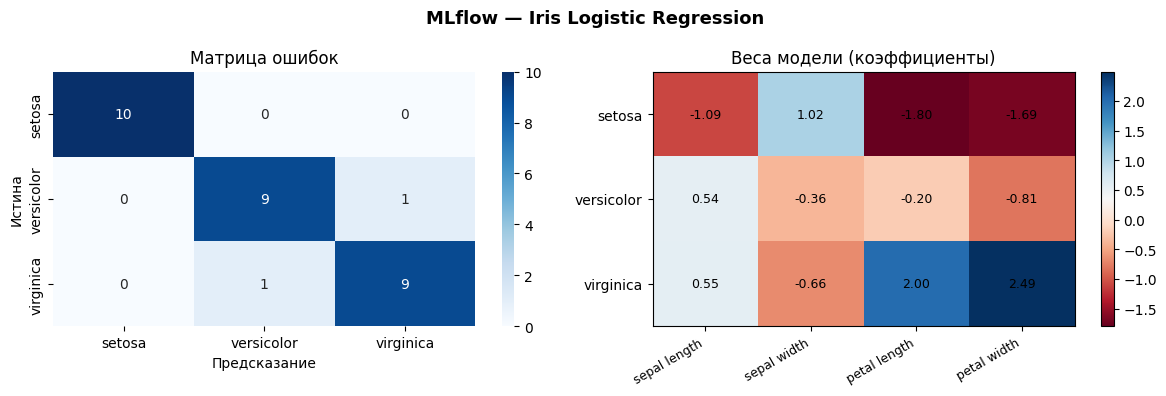

  Run ID       : ee828978ae8744c5af13c81fc1332455
  Эксперимент  : iris_logistic_regression
  Параметры:
    C=1.0, max_iter=200, solver=lbfgs
  Метрики:
    Train Accuracy : 95.83%
    Test  Accuracy : 93.33%
    F1 (weighted)  : 93.33%


  1    [5.1, 3.5, 1.4, 0.2]           setosa         98.1%         ✓
  2    [6.7, 3.0, 5.2, 2.3]           virginica      95.6%         ✓
  3    [5.9, 3.0, 4.2, 1.5]           versicolor     81.2%         ✓
sqlite:///c:/Users/Vain/Desktop/ML%20labs/ML_labs/tasks/mlflow.db


In [22]:
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

EXPERIMENT_NAME = "iris_logistic_regression"
TEST_SIZE       = 0.2
RANDOM_STATE    = 42
MAX_ITER        = 200
C               = 1.0
SOLVER          = "lbfgs"

iris        = load_iris()
X, y        = iris.data, iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name="logreg_v1") as run:
    run_id = run.info.run_id

    model = LogisticRegression(C=C, max_iter=MAX_ITER,
                                solver=SOLVER, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    y_pred    = model.predict(X_test)
    accuracy  = accuracy_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred, average="weighted")
    train_acc = accuracy_score(y_train, model.predict(X_train))

    mlflow.log_param("C",            C)
    mlflow.log_param("max_iter",     MAX_ITER)
    mlflow.log_param("solver",       SOLVER)
    mlflow.log_param("test_size",    TEST_SIZE)
    mlflow.log_param("random_state", RANDOM_STATE)
    mlflow.log_param("scaler",       "StandardScaler")

    mlflow.log_metric("accuracy_train", round(train_acc, 4))
    mlflow.log_metric("accuracy_test",  round(accuracy,  4))
    mlflow.log_metric("f1_weighted",    round(f1,        4))

    mlflow.sklearn.log_model(model, artifact_path="model",
                              registered_model_name="IrisLogisticRegression")

    cm = confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("MLflow — Iris Logistic Regression", fontsize=13, fontweight="bold")

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                xticklabels=target_names, yticklabels=target_names)
    axes[0].set_title("Матрица ошибок")
    axes[0].set_xlabel("Предсказание")
    axes[0].set_ylabel("Истина")

    coef_matrix = model.coef_
    im = axes[1].imshow(coef_matrix, cmap="RdBu", aspect="auto")
    axes[1].set_title("Веса модели (коэффициенты)")
    axes[1].set_xticks(range(len(iris.feature_names)))
    axes[1].set_xticklabels([f.replace(" (cm)", "") for f in iris.feature_names],
                             rotation=30, ha="right", fontsize=9)
    axes[1].set_yticks(range(len(target_names)))
    axes[1].set_yticklabels(target_names)
    plt.colorbar(im, ax=axes[1])
    for i in range(coef_matrix.shape[0]):
        for j in range(coef_matrix.shape[1]):
            axes[1].text(j, i, f"{coef_matrix[i,j]:.2f}",
                         ha="center", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig("mlflow_report.png", dpi=150, bbox_inches="tight")
    mlflow.log_artifact("mlflow_report.png")
    plt.show()

    print(f"  Run ID       : {run_id}")
    print(f"  Эксперимент  : {EXPERIMENT_NAME}")
    print(f"  Параметры:")
    print(f"    C={C}, max_iter={MAX_ITER}, solver={SOLVER}")
    print(f"  Метрики:")
    print(f"    Train Accuracy : {train_acc*100:.2f}%")
    print(f"    Test  Accuracy : {accuracy*100:.2f}%")
    print(f"    F1 (weighted)  : {f1*100:.2f}%")

model_uri    = f"runs:/{run_id}/model"
loaded_model = mlflow.sklearn.load_model(model_uri)

test_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],
    [6.7, 3.0, 5.2, 2.3],
    [5.9, 3.0, 4.2, 1.5],
])
labels_true = ["setosa", "virginica", "versicolor"]

test_scaled = scaler.transform(test_samples)
predictions = loaded_model.predict(test_scaled)
probas      = loaded_model.predict_proba(test_scaled)

for i, (sample, pred, proba, true) in enumerate(
        zip(test_samples, predictions, probas, labels_true)):
    name       = target_names[pred]
    confidence = proba.max()
    correct    = "✓" if name == true else "✗"
    feats      = str(sample.tolist())
    print(f"  {i+1:<4} {feats:<30} {name:<14} {confidence*100:.1f}%{'':<8} {correct}")

print(mlflow.get_tracking_uri())